In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import tensor
from torch.nn import Linear,ReLU,Sigmoid
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt
from torch.utils.tensorboard import SummaryWriter
import warnings;warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('./train_4521.csv',index_col=0).append(pd.read_csv('./test_170.csv',index_col=0))
print(df.shape)
df.head()

(4691, 27)


,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,...,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,100.5,119.2,146.5,31.978,0.272,0.132,0.059,5.293,2.570,2.819,...,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319
1,99.6,117.9,145.5,31.568,0.297,0.151,0.062,5.089,2.531,2.804,...,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303
2,100.0,118.8,145.6,31.344,0.262,0.126,0.061,5.107,2.571,2.771,...,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289
3,100.4,118.6,142.9,31.453,0.224,0.105,0.060,4.894,2.497,2.650,...,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281
4,100.4,118.1,142.2,32.190,0.243,0.117,0.061,4.946,2.503,2.695,...,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290


# define columns

In [3]:
x_cols = df.columns.tolist()[:4]
t_cols = df.columns.tolist()[:3]
y_cols = df.columns.tolist()[4:]

Na_feeds = ['C5N',
          'C6N','C6A',
          'C7N','C7A',
          'C8N','C8A',
          'C9N','C9A',
          'C10N','C10A']

P_feeds =  ['C5NP','C5IP',
           'C6NP','C6IP',
           'C7NP','C7IP',
           'C8NP','C8IP',
           'C9NP','C9IP',
           'C10NP','C10IP']

# the P columns

In [4]:
df['P'] = df[y_cols].sum(axis=1) - df['N+A']
df = df[t_cols+['N+A','P']+y_cols]
df.head()

,T10,T50,T90,N+A,P,C5NP,C5IP,C5N,C6NP,C6IP,...,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,100.5,119.2,146.5,31.978,67.815,0.272,0.132,0.059,5.293,2.570,...,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319
1,99.6,117.9,145.5,31.568,67.313,0.297,0.151,0.062,5.089,2.531,...,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303
2,100.0,118.8,145.6,31.344,67.494,0.262,0.126,0.061,5.107,2.571,...,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289
3,100.4,118.6,142.9,31.453,67.354,0.224,0.105,0.060,4.894,2.497,...,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281
4,100.4,118.1,142.2,32.190,66.593,0.243,0.117,0.061,4.946,2.503,...,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290


# scale

In [5]:
ss = StandardScaler()
df['raw_Na'] = df['N+A']
df['raw_P'] = df['P']
df[t_cols+['N+A','P']] = ss.fit_transform(df[t_cols+['N+A','P']])
df = df[t_cols+['N+A','P','raw_Na','raw_P']+Na_feeds+P_feeds]
df.head()

,T10,T50,T90,N+A,P,raw_Na,raw_P,C5N,C6N,C6A,...,C6NP,C6IP,C7NP,C7IP,C8NP,C8IP,C9NP,C9IP,C10NP,C10IP
0,0.431544,0.534148,0.475925,-1.033682,1.101289,31.978,67.815,0.059,2.819,0.494,...,5.293,2.570,10.395,8.070,9.138,9.649,6.405,9.759,0.875,5.257
1,0.348725,0.331610,0.239113,-1.082954,1.041408,31.568,67.313,0.062,2.804,0.499,...,5.089,2.531,10.074,7.958,8.970,9.548,6.324,9.899,0.881,5.591
2,0.385533,0.471829,0.262794,-1.109873,1.062999,31.344,67.494,0.061,2.771,0.492,...,5.107,2.571,10.069,7.913,9.006,9.591,6.360,9.983,0.865,5.641
3,0.422342,0.440669,-0.376600,-1.096774,1.046298,31.453,67.354,0.060,2.650,0.469,...,4.894,2.497,10.015,7.685,9.133,9.708,6.444,10.182,0.830,5.637
4,0.422342,0.362770,-0.542369,-1.008205,0.955521,32.190,66.593,0.061,2.695,0.477,...,4.946,2.503,10.053,7.765,9.101,9.676,6.416,10.115,0.835,4.823


# split

In [6]:
from sklearn.model_selection import train_test_split

X = df[t_cols+['N+A','P','raw_Na','raw_P']].to_numpy()
Y = df[Na_feeds+P_feeds].to_numpy()

X_train = X[:-170,:]
X_test = X[-170:,:]
Y_train = Y[:-170,:]
Y_test = Y[-170:,:]

#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(4521, 7)
(170, 7)
(4521, 23)
(170, 23)


# Tensor

In [7]:
X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
Y_train = torch.tensor(Y_train, dtype=torch.float)
Y_test = torch.tensor(Y_test, dtype=torch.float)

# data_iter

In [8]:
datasets = torch.utils.data.TensorDataset(X_train, Y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=128, shuffle=True)

# Construct the neural network

In [9]:
def build_FC_net(T_dim):
    net = torch.nn.Sequential(
        Linear(T_dim,128),ReLU(),
        Linear(128,128),ReLU(),
        Linear(128,T_dim),Sigmoid(),
      )
    return net

In [10]:
def build_Na_net(input_shape,output_shape):
    net = torch.nn.Sequential(
        Linear(input_shape,128),ReLU(),
        Linear(128,128),ReLU(),
        Linear(128,128),ReLU(),
        Linear(128,output_shape)
      )
    return net

In [11]:
def build_P_net(input_shape,output_shape):
    net = torch.nn.Sequential(
        Linear(input_shape,128),ReLU(),
        Linear(128,128),ReLU(),
        Linear(128,128),ReLU(),
        Linear(128,output_shape)
      )
    return net

In [12]:
def Fetch(x):
    return x[:,:5],x[:,[5]],x[:,[6]]

In [13]:
class Dual_net(nn.Module):
    def __init__(self,T_dim,Na_dim,P_dim):
        super(Dual_net,self).__init__()
        self.fc = build_FC_net(T_dim)
        self.Na_w = build_Na_net(T_dim,Na_dim) 
        self.P_w = build_P_net(T_dim,P_dim)
    
    def forward(self,x):
        x,Na_f,P_f = Fetch(x)
        x = self.fc(x)
        Na = F.softmax(self.Na_w(x),dim=1)*Na_f
        P = F.softmax(self.P_w(x),dim=1)*P_f
        return torch.cat((Na,P),dim=1)

In [14]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        try:
            m.bias.data.fill_(0)
        except:
            print(m,'no bias')

In [15]:
net = Dual_net(5,11,12)
net.apply(init_weights)

Dual_net(
  (fc): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=5, bias=True)
    (5): Sigmoid()
  )
  (Na_w): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=11, bias=True)
  )
  (P_w): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=12, bias=True)
  )
)

In [16]:
with SummaryWriter(comment='Net1')as w:
    w.add_graph(net, (X_train,))

# loss_function and optimizer

In [17]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss

In [18]:
loss_function = RMSELoss()
optimizer = optim.Adam(net.parameters(),lr=0.001)

# Training and evaluation

In [19]:
def train(net,train_iter,loss_function,optimizer,num_epochs=100):
  history = []
  for epoch in range(num_epochs):
    for x,y in train_iter:
      loss = loss_function(net(x),y)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    # end for
    print("epochs {} loss {:.4f}".format(epoch,loss.item()))
    if loss.item() < 0.40:
      break
    history.append(loss.item())
  # end for
  plt.plot(np.array(history))
  plt.title('train loss')
  return net

epochs 0 loss 1.3025
epochs 1 loss 0.9883
epochs 2 loss 1.8178
epochs 3 loss 0.8923
epochs 4 loss 1.0504
epochs 5 loss 1.4105
epochs 6 loss 0.5666
epochs 7 loss 0.5651
epochs 8 loss 0.7636
epochs 9 loss 0.5806
epochs 10 loss 0.5101
epochs 11 loss 0.9368
epochs 12 loss 1.1386
epochs 13 loss 1.0134
epochs 14 loss 0.4740
epochs 15 loss 0.7352
epochs 16 loss 0.4948
epochs 17 loss 0.7881
epochs 18 loss 0.3685


Dual_net(
  (fc): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=5, bias=True)
    (5): Sigmoid()
  )
  (Na_w): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=11, bias=True)
  )
  (P_w): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=12, bias=True)
  )
)

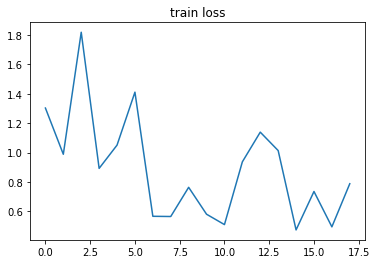

In [20]:
train(net,train_iter,loss_function,optimizer,num_epochs=200)

# predict

In [21]:
y_pred = net(X_test).detach().numpy()
y_real = Y_test.detach().numpy()
y_pred = pd.DataFrame(y_pred,columns=Na_feeds+P_feeds)[y_cols]
y_real = pd.DataFrame(y_real,columns=Na_feeds+P_feeds)[y_cols]

In [22]:
y_pred.head()

,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,...,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,1.106391,0.763712,0.255339,3.564919,2.452062,3.627848,0.635229,7.602136,6.240958,9.384884,...,6.939537,5.931255,5.095508,9.493838,5.101100,3.510631,1.285223,5.355256,0.821322,0.852895
1,0.226409,0.156069,0.168012,3.182361,1.162383,2.112807,0.502783,10.573259,7.576332,6.356643,...,4.994627,5.657137,6.693305,10.488802,4.573127,3.810063,1.145347,5.979194,0.620745,0.638891
2,0.229246,0.158489,0.173839,3.240197,1.182137,2.054858,0.505222,10.613758,7.547668,6.143574,...,4.817384,5.538920,6.785885,10.596862,4.449513,3.781353,1.208159,6.157507,0.627744,0.658814
3,0.229181,0.160139,0.154877,3.319795,1.186226,2.031019,0.490379,10.575169,7.469931,6.117370,...,4.829967,5.668126,6.847372,10.641375,4.466631,3.755072,1.162980,6.089980,0.582535,0.595302
4,0.232008,0.160896,0.169761,3.166948,1.184308,2.094943,0.508210,10.365999,7.376892,6.352480,...,5.014897,5.789071,6.745070,10.528359,4.575449,3.880445,1.204189,6.165174,0.632716,0.660186


In [23]:
y_real.head()

,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,...,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,1.142,0.616,0.217,3.745,2.577,4.028,0.557,7.669,5.9900,10.206,...,7.039,5.438,5.263,9.537,4.877,3.481,1.088,5.652,0.618,0.597
1,0.122,0.078,0.029,3.955,1.563,2.407,0.400,10.016,7.2633,6.573,...,5.135,5.482,6.793,10.850,4.308,3.963,1.069,6.025,0.585,0.484
2,0.098,0.064,0.020,3.920,1.447,2.296,0.396,10.236,7.3480,6.259,...,4.942,5.453,6.947,10.996,4.269,3.997,1.034,6.107,0.543,0.456
3,0.122,0.085,0.021,3.900,1.437,2.274,0.397,10.259,7.3560,6.234,...,4.928,5.476,6.953,11.026,4.264,3.982,1.013,6.054,0.545,0.449
4,0.072,0.049,0.015,3.873,1.369,2.206,0.489,10.213,7.3190,6.009,...,4.769,6.584,6.866,10.892,4.169,4.227,0.930,5.828,0.519,0.463


In [24]:
res = pd.DataFrame(index=y_cols,columns=['R2','RMSE'])
for i in y_cols:
  res.loc[i,'R2'] = r2_score(y_real[i],y_pred[i])
  res.loc[i,'RMSE'] = sqrt(mean_squared_error(y_real[i],y_pred[i]))
res.loc['AVG'] = res.mean(axis=0)
res

,R2,RMSE
C5NP,0.864057,0.315089
C5IP,0.742398,0.259724
C5N,0.35687,0.109785
C6NP,0.0508855,0.394149
C6IP,0.899149,0.331945
C6N,0.892083,0.544021
C6A,0.605793,0.107269
C7NP,0.977446,0.330289
C7IP,0.851423,0.425932
C7N,0.965494,0.774119


In [25]:
temp = pd.DataFrame()
temp['real'] = y_real[Na_feeds].sum(axis=1).values
temp['pred'] = y_pred[Na_feeds].sum(axis=1).values
temp

,real,pred
0,40.132999,40.132999
1,32.174999,32.174999
2,31.427998,31.428005
3,31.389997,31.389999
4,32.417999,32.417995
...,...,...
165,53.841000,53.840996
166,53.442001,53.442001
167,52.549004,52.549000
168,49.827003,49.827003
